In [1]:
import os
import tempfile
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import BinaryAccuracy,Precision,Recall,AUC,MeanSquaredError,MeanAbsolutePercentageError,RootMeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy,BinaryFocalCrossentropy,MeanSquaredError,MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def f1(y_true, y_pred):
    from keras import backend as K
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
def plot_history_metrics(history,metrics=None,columns=3):
  if metrics is None:
    metrics = [x for x in history.history.keys() if 'val' not in x]
  rows = math.ceil(len(metrics)/columns)
  
  if len(metrics) < columns:
    columns = len(metrics)

  width = columns * 8

  height = rows * 8

  fig,axs = plt.subplots(rows,columns,figsize=(width,height))

  if len(metrics) == 1:
    name = metrics[0].replace("_"," ").capitalize()
    axs.plot(history.epoch, history.history[metrics[0]], color=colors[0], label='Train')
    axs.plot(history.epoch, history.history['val_'+metrics[0]],color=colors[0], linestyle="--", label='Val')
    axs.set_title(name)
    axs.set_xlabel('Epoch')
    axs.set_ylabel(metrics[0])

    axs.legend()

  else:

    axs = axs.ravel()

    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      axs[n].plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      axs[n].plot(history.epoch, history.history['val_'+metric],color=colors[0], linestyle="--", label='Val')
      axs[n].set_title(name)
      axs[n].set_xlabel('Epoch')
      axs[n].set_ylabel(name)

      axs[n].legend()
  plt.show()

In [5]:
df = pd.read_csv('creditcard.csv').drop(['Time'],axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.88,10.07,-9.83,-2.07,-5.36,-2.61,-4.92,7.31,1.91,4.36,...,0.21,0.11,1.01,-0.51,1.44,0.25,0.94,0.82,0.77,0
284803,-0.73,-0.06,2.04,-0.74,0.87,1.06,0.02,0.29,0.58,-0.98,...,0.21,0.92,0.01,-1.02,-0.61,-0.40,0.07,-0.05,24.79,0
284804,1.92,-0.30,-3.25,-0.56,2.63,3.03,-0.30,0.71,0.43,-0.48,...,0.23,0.58,-0.04,0.64,0.27,-0.09,0.00,-0.03,67.88,0
284805,-0.24,0.53,0.70,0.69,-0.38,0.62,-0.69,0.68,0.39,-0.40,...,0.27,0.80,-0.16,0.12,-0.57,0.55,0.11,0.10,10.00,0


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

target1 = ['Class']
target2 = ['Amount']
removes = ['Amount','Class']

y1_train = train_df[target1]
y2_train = train_df[target2]
x_train = train_df.copy().drop(removes,axis=1)

y1_test = test_df[target1]
y2_test = test_df[target2]
x_test = test_df.copy().drop(removes,axis=1)

y1_val = val_df[target1]
y2_val = val_df[target2]
x_val = val_df.copy().drop(removes,axis=1)

In [7]:
print("Train Records: {} Percent: {:.2%} Positive Labels: {} Percent: {:.4%}".format(len(y1_train),len(y1_train)/len(df),np.count_nonzero(y1_train),np.count_nonzero(y1_train)/len(y1_train)))
print("Val Records: {} Percent: {:.2%} Positive Labels: {} Percent: {:.4%}".format(len(y1_val),len(y1_val)/len(df),np.count_nonzero(y1_val),np.count_nonzero(y1_val)/len(y1_val)))
print("Test Records: {}  Percent: {:.2%} Positive Labels: {} Percent: {:.4%}".format(len(y1_test),len(y1_test)/len(df),np.count_nonzero(y1_test),np.count_nonzero(y1_test)/len(y1_test)))

Train Records: 182276 Percent: 64.00% Positive Labels: 285 Percent: 0.1564%
Val Records: 45569 Percent: 16.00% Positive Labels: 98 Percent: 0.2151%
Test Records: 56962  Percent: 20.00% Positive Labels: 109 Percent: 0.1914%


In [8]:
early_stopping = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)
batch_size = 2048
epochs = 100

In [9]:
def bias_builder(arr):
    return np.log(np.count_nonzero(arr)/len(arr))

def build_binary_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    first_dense = Dense(units=28,activation='elu',name="first_dense")(input_layer)
    first_dropout = Dropout(.5)(first_dense)
    last_layer = Dense(units=16,activation='elu',name="last_dense")(first_dense)
    last_dropout = Dropout(.5)(last_layer)

    binary_output = Dense(units=1,activation='sigmoid',name='binary_output',bias_initializer=Constant(bias_builder(y1_train)))(last_layer)

    model = Model(inputs=input_layer,outputs=binary_output,name="binary_model")

    return model

In [10]:
binary_model = build_binary_model()
binary_model.summary()

Model: "binary_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28)]              0         
                                                                 
 first_dense (Dense)         (None, 28)                812       
                                                                 
 last_dense (Dense)          (None, 16)                464       
                                                                 
 binary_output (Dense)       (None, 1)                 17        
                                                                 
Total params: 1,293
Trainable params: 1,293
Non-trainable params: 0
_________________________________________________________________


In [11]:
binary_model.compile(optimizer=SGD(learning_rate=.01),loss=BinaryCrossentropy(),metrics=[f1,AUC(name='auc')])

binary_history = binary_model.fit(x_train,y1_train,batch_size=batch_size,epochs=epochs,callbacks=[early_stopping],validation_data=(x_val, y1_val),verbose=0)

In [12]:
binary_results = binary_model.evaluate(x_test, y1_test, batch_size=batch_size,verbose=0)
print("Binary Loss: {:.4f} F1: {:.4f} AUC: {:.4f}".format(*binary_results))

Binary Loss: 0.0054 F1: 0.6431 AUC: 0.9298


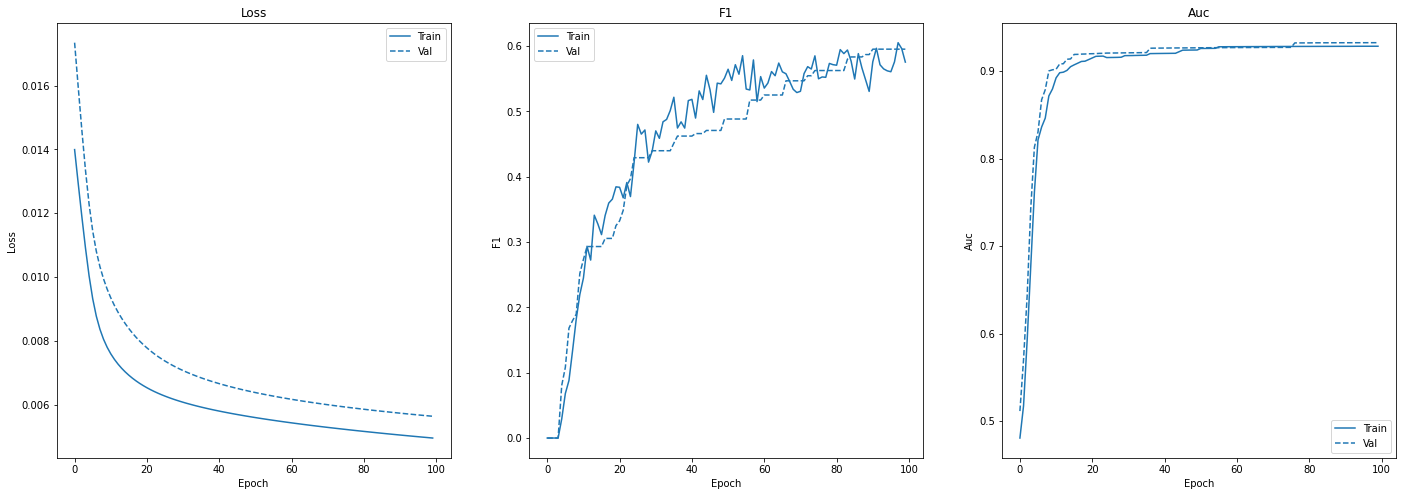

In [13]:
plot_history_metrics(binary_history)

In [14]:
def build_regression_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    first_dense = Dense(units=28,activation='elu',name="first_dense")(input_layer)
    first_dropout = Dropout(.5)(first_dense)
    last_layer = Dense(units=16,activation='elu',name="last_dense")(first_dense)
    last_dropout = Dropout(.5)(last_layer)

    regression_output = Dense(units=1,name='regression_output')(last_layer)

    model = Model(inputs=input_layer,outputs=regression_output,name="regression_model")

    return model

In [15]:
regression_model = build_regression_model()

regression_model.summary()

Model: "regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28)]              0         
                                                                 
 first_dense (Dense)         (None, 28)                812       
                                                                 
 last_dense (Dense)          (None, 16)                464       
                                                                 
 regression_output (Dense)   (None, 1)                 17        
                                                                 
Total params: 1,293
Trainable params: 1,293
Non-trainable params: 0
_________________________________________________________________


In [16]:
regression_model.compile(optimizer=SGD(learning_rate=.01),loss=MeanSquaredLogarithmicError(),metrics=[MeanSquaredError(name='mse'),MeanAbsolutePercentageError(name='mape')])

regression_history = regression_model.fit(x_train,y2_train,batch_size=batch_size,epochs=epochs,callbacks=[early_stopping],validation_data=(x_val, y2_val), verbose=0)

Restoring model weights from the end of the best epoch: 90.
Epoch 100: early stopping


In [17]:
regression_results = regression_model.evaluate(x_test, y2_test, batch_size=batch_size, verbose=0)
print("Regression Loss: {:.4f} MSE: {:.4f} MAPE: {:.4f}".format(*regression_results))

Regression Loss: 0.2172 MSE: 6675.7925 MAPE: 52487220.0000


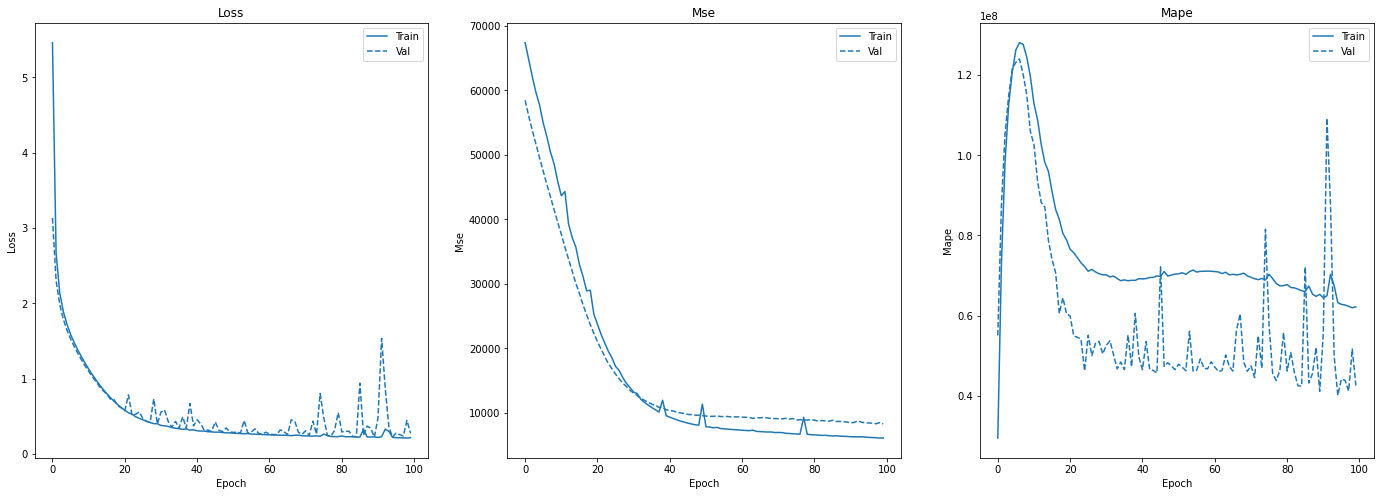

In [18]:
plot_history_metrics(regression_history)

In [19]:
y2hat_test  =regression_model.predict(x_test, verbose=0)

In [20]:
test_results = y2_test.copy()
test_results['Class'] = y1_test
test_results['Prediction'] = y2hat_test
test_results['Difference'] = test_results['Amount']-test_results['Prediction']
test_results['Increase'] = test_results['Difference']/test_results['Prediction']
test_results.sort_values(['Difference'],ascending=[True]).head(10)

,Amount,Class,Prediction,Difference,Increase
231454,3552.96,0,7222.95,-3669.99,-0.51
219640,1417.29,0,4725.87,-3308.58,-0.70
117661,34.05,0,3288.39,-3254.34,-0.99
220090,5964.95,0,9127.60,-3162.65,-0.35
262378,2074.69,0,4800.78,-2726.09,-0.57
219257,3502.11,0,6147.15,-2645.04,-0.43
70031,9.00,0,2592.58,-2583.58,-1.00
121787,1729.79,0,4247.19,-2517.40,-0.59
209292,458.97,0,2962.05,-2503.08,-0.85
243702,430.00,0,2822.06,-2392.06,-0.85


In [21]:
test_results.set_index(['Class'])[['Difference']].stack().groupby(level=0).describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,56853.00,8.34,81.37,-3669.99,0.13,2.53,9.85,3956.52
1,109.00,0.94,105.68,-434.52,-5.60,5.58,27.34,365.14


In [22]:
def build_multitask_model():
    input_layer = Input(shape=(x_train.shape[-1],), name="input_layer")

    first_dense = Dense(units=28,activation='elu',name="first_dense")(input_layer)
    first_dropout = Dropout(.5)(first_dense)
    last_layer = Dense(units=16,activation='elu',name="last_dense")(first_dense)
    last_dropout = Dropout(.5)(last_layer)

    binary_output = Dense(units=1,activation='sigmoid',name='binary_output',bias_initializer=Constant(bias_builder(y1_train)))(last_layer)
    regression_output = Dense(units=1,name='regression_output')(last_layer)

    model = Model(inputs=input_layer,outputs=[binary_output,regression_output],name="multitask_model")

    return model

In [23]:
multitask_model = build_multitask_model()

multitask_model.summary()

Model: "multitask_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28)]         0           []                               
                                                                                                  
 first_dense (Dense)            (None, 28)           812         ['input_layer[0][0]']            
                                                                                                  
 last_dense (Dense)             (None, 16)           464         ['first_dense[0][0]']            
                                                                                                  
 binary_output (Dense)          (None, 1)            17          ['last_dense[0][0]']             
                                                                                    

In [24]:
multitask_model.compile(
    optimizer=SGD(learning_rate=.01),
    loss={
        "binary_output":BinaryCrossentropy(),
        "regression_output":MeanSquaredLogarithmicError()
        },
    loss_weights={
        "binary_output":5.0,
        "regression_output":1.0
        },
    metrics={
        "binary_output":[f1,AUC(name='auc')],
        "regression_output":[MeanSquaredError(name='mse'),MeanAbsolutePercentageError(name='mape')]
        }
    )

multitask_history = multitask_model.fit(x_train,[y1_train,y2_train],batch_size=batch_size,epochs=epochs,callbacks=[early_stopping],validation_data=(x_val, [y1_val,y2_val]),verbose=0)

In [25]:
multitask_results = multitask_model.evaluate(x_test, [y1_test, y2_test], batch_size=batch_size, verbose=0)
print("Overall Loss: {0:.4f} \nBinary Loss: {1:.4f} F1: {3:.4f} AUC: {4:.4f}\nRegression Loss: {2:.4f} MSE: {5:.4f} MAPE: {6:.4f}".format(*multitask_results))

Overall Loss: 0.2315 
Binary Loss: 0.0041 F1: 0.6963 AUC: 0.9257
Regression Loss: 0.2112 MSE: 5869.1548 MAPE: 39766400.0000


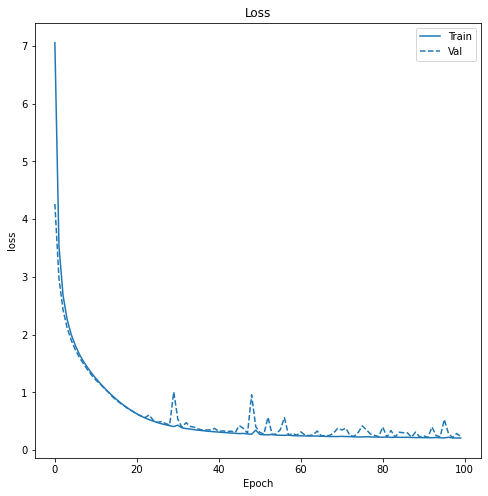

In [26]:
plot_history_metrics(multitask_history,['loss'])

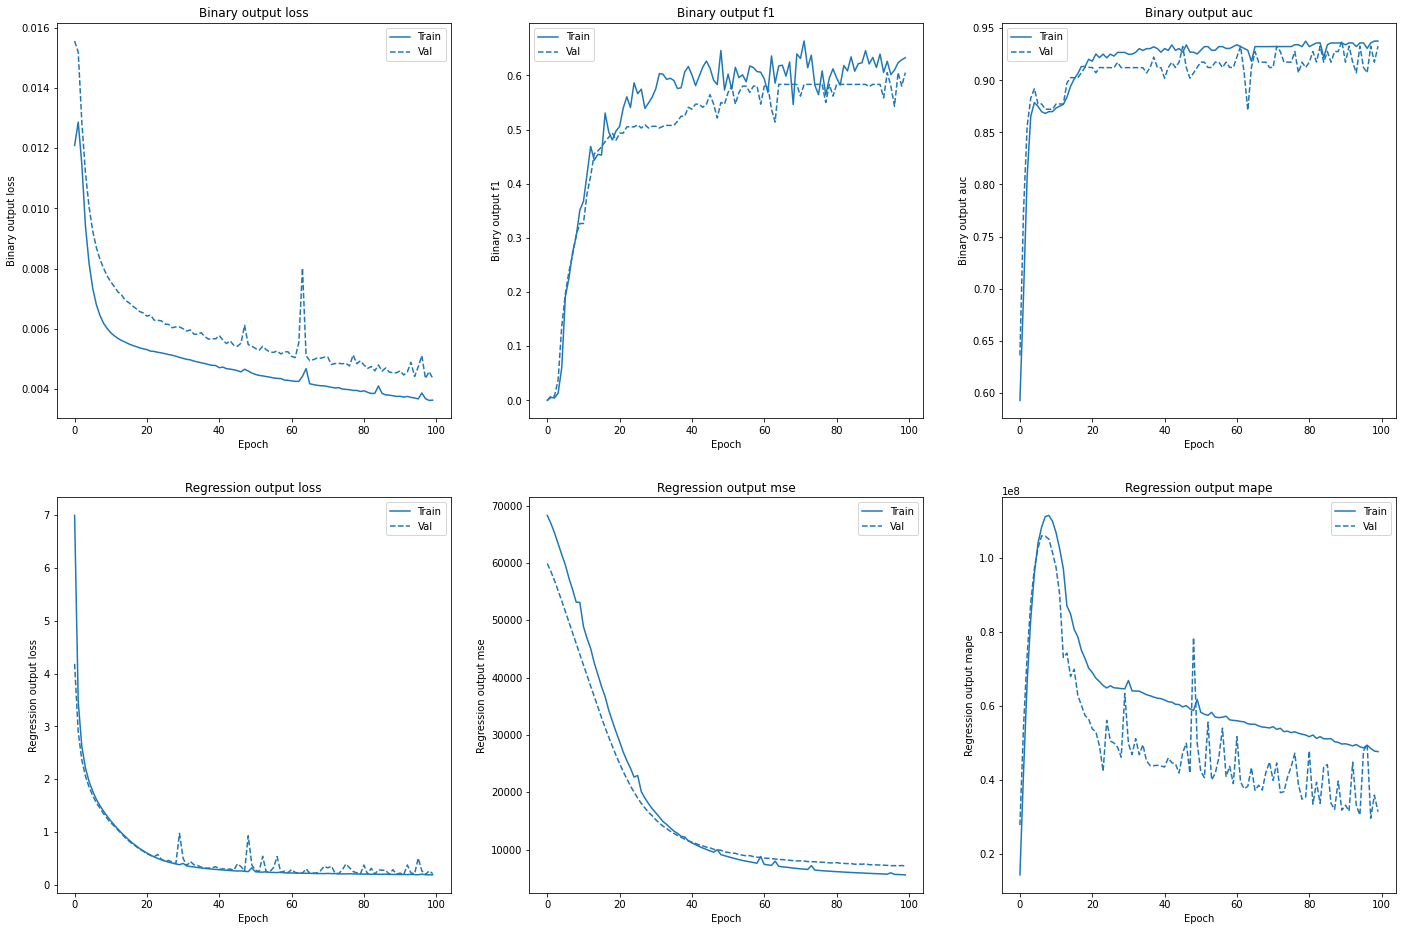

In [27]:
plot_history_metrics(multitask_history,['binary_output_loss','binary_output_f1','binary_output_auc','regression_output_loss', 'regression_output_mse', 'regression_output_mape'])

In [28]:
yhat1_test,yhat2_test = multitask_model.predict(x_test, verbose=0)

In [29]:
comb_test_results = y1_test.copy()
comb_test_results['Amount'] = y2_test
comb_test_results['Class Prediction'] = yhat1_test
comb_test_results['Amount Prediction'] = yhat2_test
comb_test_results['Difference'] = comb_test_results['Amount']-comb_test_results['Amount Prediction']
comb_test_results['Increase'] = comb_test_results['Difference']/comb_test_results['Amount Prediction']
comb_test_results.sort_values(['Difference'],ascending=[False]).head(10)

,Class,Amount,Class Prediction,Amount Prediction,Difference,Increase
274771,0,25691.16,0.99,21898.88,3792.28,0.17
91896,0,6000.00,0.00,2304.27,3695.73,1.60
169457,0,11789.84,0.00,8399.36,3390.48,0.40
19760,0,7879.42,0.00,5628.94,2250.48,0.40
228525,0,6998.00,0.00,5007.94,1990.06,0.40
130046,0,5667.56,0.00,4068.43,1599.13,0.39
74243,0,5259.00,0.00,3779.08,1479.92,0.39
54696,0,5130.30,0.00,3682.05,1448.25,0.39
227636,0,4959.85,0.00,3569.60,1390.25,0.39
44947,0,4276.82,0.01,2930.41,1346.41,0.46


In [30]:
comb_test_results.set_index(['Class'])[['Difference']].stack().groupby(level=0).describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,56853.00,9.33,75.92,-3015.20,0.42,1.77,6.08,3792.28
1,109.00,-48.51,153.07,-558.47,-66.89,3.11,13.66,383.49
